## Feature Selection
<hr style="height:1px;border:none;color:#333;background-color:#333;" />

note: jupyter nbconvert "Feature Selection2.ipynb" --to slides --post serve --SlidesExporter.reveal_theme=serif --SlidesExporter.reveal_scroll=True --no-input

## Table of Contents

* [1.1 Environment Setup](#env-setup)
    * [1.1.1 Importing Modules](#imports)
    * [1.1.2 Display Settings](#display-setup)
    * [1.1.3 Load Data](#read-file)
<br><br>
* [1.2 Preparing Data for Feature Selection](#eda)
    * [1.2.1 Grouping Variables by Type](#var-type)
    * [1.2.2 Remove Abnormal Sales](#ras)
    * [1.2.3 Combining Number Basement Bathrooms](#cnbb)
    * [1.2.4 Remove Numeric Features With Less Than 20% of Unique Observations](#rnf)
    * [1.2.5 Remove Nominal Variables With Less Than 10% of Unique Observations](#rnf)
    * [1.2.6 Converting Ordinal Variables to Numeric](#covn)
    * [1.2.7 Dummifying Nominal Variables](#dnr)
    * [1.2.8 Investigating MultiCollinearity: Correlation Matrix (continuous variables)](#imcm)
    * [1.2.9 Correlation Against Target Variable (SalePrice)](#catv)
    * [1.2.10 Checking for Normality: Dependent Variable](#cndv)
    * [1.2.11 Checking for Normality: Independent Variables](#cniv)
<br><br>
* [1.3 Feature Selection](#fs)
    * [1.3.1 Using Lasso Regression to Select Features](#lasso)
<br><br>
* [1.4 Descriptive Modeling](#dm)
    * [1.4.1 Train and Test data](#ttd)
    * [1.4.2 Multiple Linear Regression with all the features](#mlr)
    * [1.4.3 Multiple Linear Regresion with limited number of features](#mlr2)
    * [1.4.4 Evaluating p-values and R-squared using Statmodels](#statmodel)
    * [1.4.5 Further narrowing of the number of features](#fnnf)
<br><br>
* [1.5 Evaluating Overall Quality, Fence, and Roof](#eval-section)
    * [1.5.1 Roof Material](#roof-material)
    * [1.5.2 Fence Quality](#fence-quality)
    * [1.5.3 Overall Quality of the House](#overall-quality)

### 1.1 Environment Setup  <a class="anchor" id="env-setup"></a>

#### 1.1.1 Importing Modules<a class="anchor" id="imports"></a>

In [1]:
# import modules
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import warnings
import statsmodels.formula.api as smf
from scipy import stats
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings("ignore")

#### 1.1.2 Display Settings<a class="anchor" id="display-setup"></a>

In [2]:
pd.set_option('display.max_columns', None) # display all the columns of a dataframe
pd.set_option('display.max_rows', 100)     # display 100 rows of a dataframe

#### 1.1.3 Load data<a class="anchor" id="read-file"></a>

In [3]:
# Load cleaned data - see "Data Cleansing.ipynb"
dataset = pd.read_csv('../ariel/Price_Data_cleaned.csv')

<br><br>
<hr style="height:1px;border:none;color:#333;background-color:#333;" />

### 1.2 Preparing Data for Modeling<a class="anchor" id="eda"></a>

#### 1.2.1 Grouping Variables by Type<a class="anchor" id="var-type"></a>

In [4]:
continuous_variables = ['GrLivArea', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 
                       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GarageArea', 'WoodDeckSF',
                       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
                       'SalePrice', 'LotFrontage']

discrete_variables = ['YearBuilt', 'YearRemodAdd', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
                      'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars',
                      'MoSold', 'YrSold']

nominal_variables = ['MSSubClass', 'Alley', 'LandContour', 'MSZoning', 'LotConfig', 'Neighborhood',
                     'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
                     'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Street', 'Heating',
                     'GarageType', 'CentralAir', 'MiscFeature', 'SaleType', 'SaleCondition']

ordinal_variables = ['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
                     'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC',
                     'GarageFinish', 'PavedDrive', 'Fence', 'Functional', 'BsmtFinType2', 'Electrical',
                     'BsmtFinType1','BsmtExposure', 'LandSlope', 'Utilities', 'LotShape',]


#### 1.2.2 Remove Abnormal Sales<a class="anchor" id="ras"></a>
<br>
Only include sales that were completed under 'normal' circumstances. The other type of sales (foreclosure, short sale, etc...) only account for 6% of the observations.

In [5]:
dataset = dataset[dataset['SaleCondition']=='Normal']

In [6]:
# Drop SaleCondition since all the sales are now 'Normal'
dataset.drop(columns='SaleCondition', inplace=True)

#### 1.2.3 Combining Number Basement Bathrooms<a class="anchor" id="cnbb"></a>

In [7]:
# Combine BsmtFullBath and BsmtHalfBath
dataset['BsmtNumBath'] = dataset['BsmtFullBath'] + dataset['BsmtHalfBath'] / dataset['BsmtHalfBath'].max()
# Total number of bathrooms above grade
dataset['TotalNumBath'] = dataset['FullBath'] + dataset['HalfBath'] / dataset['HalfBath'].max()
# Drop orginal features
dataset.drop(columns=['BsmtFullBath','BsmtHalfBath','FullBath','HalfBath'], inplace=True)

#### 1.2.4 Remove Numeric Features With Less Than 20% of Unique Observations<a class="anchor" id="rnf"></a>

In [8]:
# Removing the following features since they are only present in less than 20% of the observations
((dataset.select_dtypes(['int','float'])==0).sum()/dataset.shape[0]).sort_values(ascending=False).head(10)


BsmtFinSF2      0.867799
MasVnrArea      0.615416
BsmtNumBath     0.522586
BsmtFinSF1      0.294654
BsmtUnfSF       0.084542
GarageArea      0.048073
GarageCars      0.048073
GarageYrBlt     0.048073
TotalBsmtSF     0.027766
TotalNumBath    0.000829
dtype: float64

In [9]:
dataset.drop(columns=['PoolArea', '3SsnPorch', 'LowQualFinSF', 'MiscVal','ScreenPorch','BsmtFinSF2','EnclosedPorch'], axis=1, inplace=True)

#### 1.2.5 Remove Nominal Variables With Less Than 20% of Unique Observations<a class="anchor" id="rnf"></a>

In [10]:
# Removing the following nominal variables since they are only present in less than 20% of the observations.
((dataset.select_dtypes('object')=='None').sum()/2413).sort_values(ascending=False).head(10)

PoolQC          0.996270
MiscFeature     0.960215
Alley           0.936179
Fence           0.791960
MasVnrType      0.618317
FireplaceQu     0.482387
GarageCond      0.048073
GarageQual      0.048073
GarageFinish    0.048073
GarageType      0.048073
dtype: float64

In [11]:
dataset.drop(columns=['PoolQC', 'MiscFeature', 'Alley'], axis=1, inplace=True)

#### 1.2.6 Converting Ordinal Variables to Numeric<a class="anchor" id="covn"></a>

In [12]:
# Encoding Ordinal Variables
dict_1 = {'None':0, 'No':1, 'Mn':2, 'Av':3, 'Gd':4}
dict_2 = {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
dict_3 = {'None':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}
dict_4 = {"None":0, "Unf":1, "RFn":2, "Fin":3}
dict_5 = {"N":1, "P":2, "Y":3}
dict_6 = {"None":0, "MnWw":1, "GdWo":2, "MnPrv":3, "GdPrv":4}
dict_7 = {"Sal":1, "Sev":2, "Maj2":3, "Maj1":4, "Mod":5, "Min2":6, "Min1":7, "Typ":8}
dict_8 = {"Mix":1, "FuseP":2, "FuseF":3, "FuseA":4, "SBrkr":5}
dict_9 = {"Sev":1, "Mod":2, "Gtl":3}
dict_10 = {"ELO":1, "NoSeWa":2, "NoSewr":3, "AllPub":4}
dict_11 = {"IR3":1, "IR2":2, "IR1":3, "Reg":4}

dataset.BsmtExposure.replace(dict_1, inplace=True)
dataset.ExterQual.replace(dict_2, inplace=True)
dataset.ExterCond.replace(dict_2, inplace=True)
dataset.BsmtQual.replace(dict_2, inplace=True)
dataset.BsmtCond.replace(dict_2, inplace=True)
dataset.HeatingQC.replace(dict_2, inplace=True)
dataset.KitchenQual.replace(dict_2, inplace=True)
dataset.FireplaceQu.replace(dict_2, inplace=True)
dataset.GarageQual.replace(dict_2, inplace=True)
dataset.GarageCond.replace(dict_2, inplace=True)
# dataset.PoolQC.replace(dict_2, inplace=True)
dataset.BsmtFinType1.replace(dict_3, inplace=True)
dataset.BsmtFinType2.replace(dict_3, inplace=True)
dataset.GarageFinish.replace(dict_4, inplace=True)
dataset.PavedDrive.replace(dict_5, inplace=True)
dataset.Fence.replace(dict_6, inplace=True)
dataset.Functional.replace(dict_7, inplace=True)
dataset.Electrical.replace(dict_8, inplace=True)
dataset.LandSlope.replace(dict_9, inplace=True)
dataset.Utilities.replace(dict_10, inplace=True)
dataset.LotShape.replace(dict_11, inplace=True)

#### 1.2.7 Dummifying Nominal Variables<a class="anchor" id="dnr"></a>

In [13]:
# update the nominal_variables list by removing the columns removed in the previous section
nominal_variables_updated = list(set(nominal_variables)-set(['PoolQC', 'MiscFeature', 'Alley', 'SaleCondition']))

In [14]:
# set the MSSubClass column to object, since it is a nominal variable
dataset['MSSubClass'] = dataset['MSSubClass'].astype(object)
# new dataset that will hold the encoded categorical variables + all the others
dataset_encoded = dataset.copy()
# Encode all categorical nominal variables
for column_name in nominal_variables_updated:
    dataset_encoded = pd.concat([dataset_encoded, pd.get_dummies(dataset_encoded[column_name], prefix=column_name, drop_first=True)], axis=1)
# Remove original categorical columns
dataset_encoded = dataset_encoded.drop(nominal_variables_updated, axis=1)

#### 1.2.8 Investigating MultiCollinearity: Correlation Matrix (continuous variables)<a class="anchor" id="imcm"></a>

In [15]:
continuous_variables_updated = list(set(continuous_variables)-set(['MiscVal', 'ScreenPorch', '3SsnPorch', 'LowQualFinSF', 'PoolArea','BsmtFinSF2','EnclosedPorch']))

In [16]:
# Generate correlation matrix (continues variables only)
corr_matrix = dataset[continuous_variables_updated].corr(method="pearson") # pearson? kendall? which is best

In [17]:
# List of highly (>0.85) correlated pair of variables
c_m = list(corr_matrix.columns)
for index_ in corr_matrix.columns:
    c_m.remove(index_)
    for feature in c_m:
        if abs(corr_matrix.loc[index_,feature])>0.85:
            print(index_,"_",feature,": ",corr_matrix.loc[index_,feature], sep="")

<AxesSubplot:>

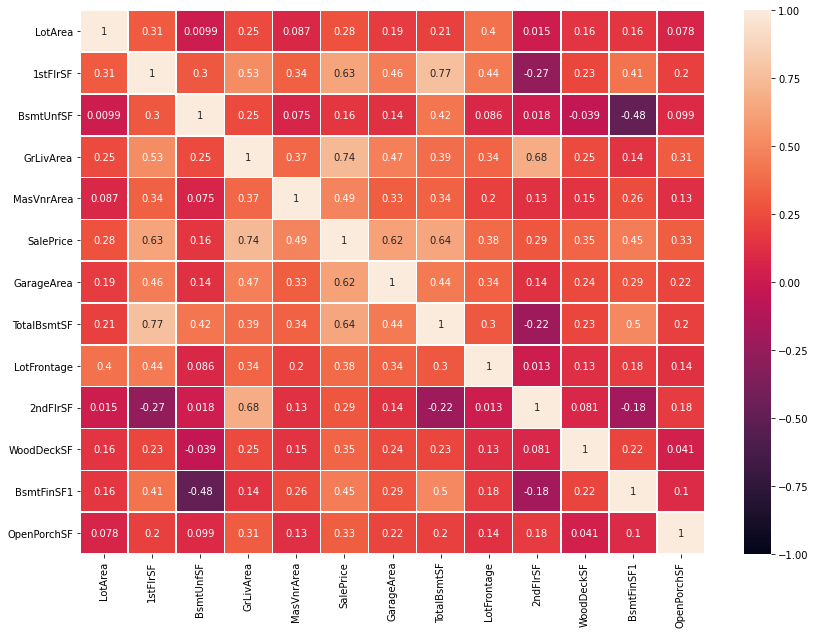

In [18]:
plt.figure(figsize=(14,10))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, linewidths=.5, annot=True)

<b>Conclusion:</b> correlation between features is within reasonable values, no feature will be removed.

#### 1.2.9 Correlation Against Target Variable (SalePrice)<a class="anchor" id="catv"></a>

In [19]:
# Remove features with low correlation (<0.01) with the target variable(SalePrice)
corr_matrix['SalePrice'].abs().sort_values(ascending=False)

SalePrice      1.000000
GrLivArea      0.736036
TotalBsmtSF    0.642354
1stFlrSF       0.634672
GarageArea     0.621900
MasVnrArea     0.486620
BsmtFinSF1     0.454087
LotFrontage    0.382420
WoodDeckSF     0.350127
OpenPorchSF    0.326489
2ndFlrSF       0.293338
LotArea        0.275066
BsmtUnfSF      0.159724
Name: SalePrice, dtype: float64

<b>Conslusion:</b> no features will be removed since correlation between target variable and features is within reasonable values.


#### 1.2.10 Checking for Normality: Dependent Variable<a class="anchor" id="cndv"></a>

variable = y
Median: 159000.0
Mean: 175567.64318276005
Skew: 1.7453580480340125
Kurtosis: 5.825763749688768
--------------------------------------------------
variable = log10(y)
Median: 5.201397124320452
Mean: 5.244444479212366
Skew: 0.24188453291963574
Kurtosis: 0.7653528688452214


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

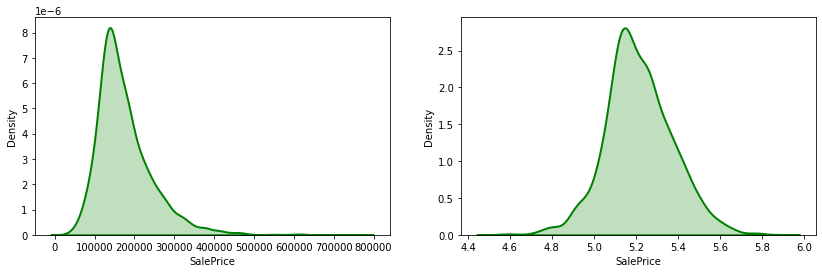

In [20]:
# Check Target variable for normal distribution
print('variable = y')
print("Median: " + str(dataset_encoded['SalePrice'].median()))
print("Mean: " + str(dataset_encoded['SalePrice'].mean()))
print("Skew: " + str(dataset_encoded['SalePrice'].skew()))
print("Kurtosis: " + str(dataset_encoded['SalePrice'].kurtosis()))
print("-"*50)
# log10
print("variable = log10(y)")
print("Median: " + str(np.log10(dataset_encoded['SalePrice'].median())))
print("Mean: " + str(np.log10(dataset_encoded['SalePrice'].mean())))
print("Skew: " + str(np.log10(dataset_encoded['SalePrice'].skew())))
print("Kurtosis: " + str(np.log10(dataset_encoded['SalePrice'].kurtosis())))
# creating axes to draw plots 
fig, ax = plt.subplots(1, 2, figsize=(14,4)) 
sns.distplot(dataset_encoded['SalePrice'], hist = False, kde = True, 
            kde_kws = {'shade': True, 'linewidth': 2},  
            label = "Original", color ="green", ax = ax[0]) 
sns.distplot(np.log10(dataset_encoded['SalePrice']), hist = False, kde = True, 
            kde_kws = {'shade': True, 'linewidth': 2},  
            label = "log10", color ="green", ax = ax[1])


<b>Conclusion:</b> Calculating the log10 of the target variable produces a distribution closer to the normal distribution.

#### 1.2.11 Checking for Normality: Independent Variables<a class="anchor" id="cniv"></a>

In [21]:
# Continuous variables -> skewness
cont_var_skew = pd.DataFrame((dataset_encoded[continuous_variables_updated]).skew().abs()).reset_index()
cont_var_log_skew = pd.DataFrame(np.log10(dataset_encoded[continuous_variables_updated]+1).skew().abs()).reset_index()
cont_var_skew.columns = ['feature','skewness']
cont_var_log_skew.columns = ['feature','skewness_log']
cont_skew = cont_var_skew.merge(cont_var_log_skew, on="feature", how="inner")
cont_skew

,feature,skewness,skewness_log
0,LotArea,13.393921,0.513180
1,1stFlrSF,1.043301,0.024600
2,BsmtUnfSF,0.978891,2.129723
3,GrLivArea,0.940956,0.036984
4,MasVnrArea,2.750254,0.586703
5,SalePrice,1.745358,0.155859
6,GarageArea,0.192519,3.738757
7,TotalBsmtSF,0.456386,4.948562
8,LotFrontage,1.137594,1.112926
9,2ndFlrSF,0.804118,0.269066


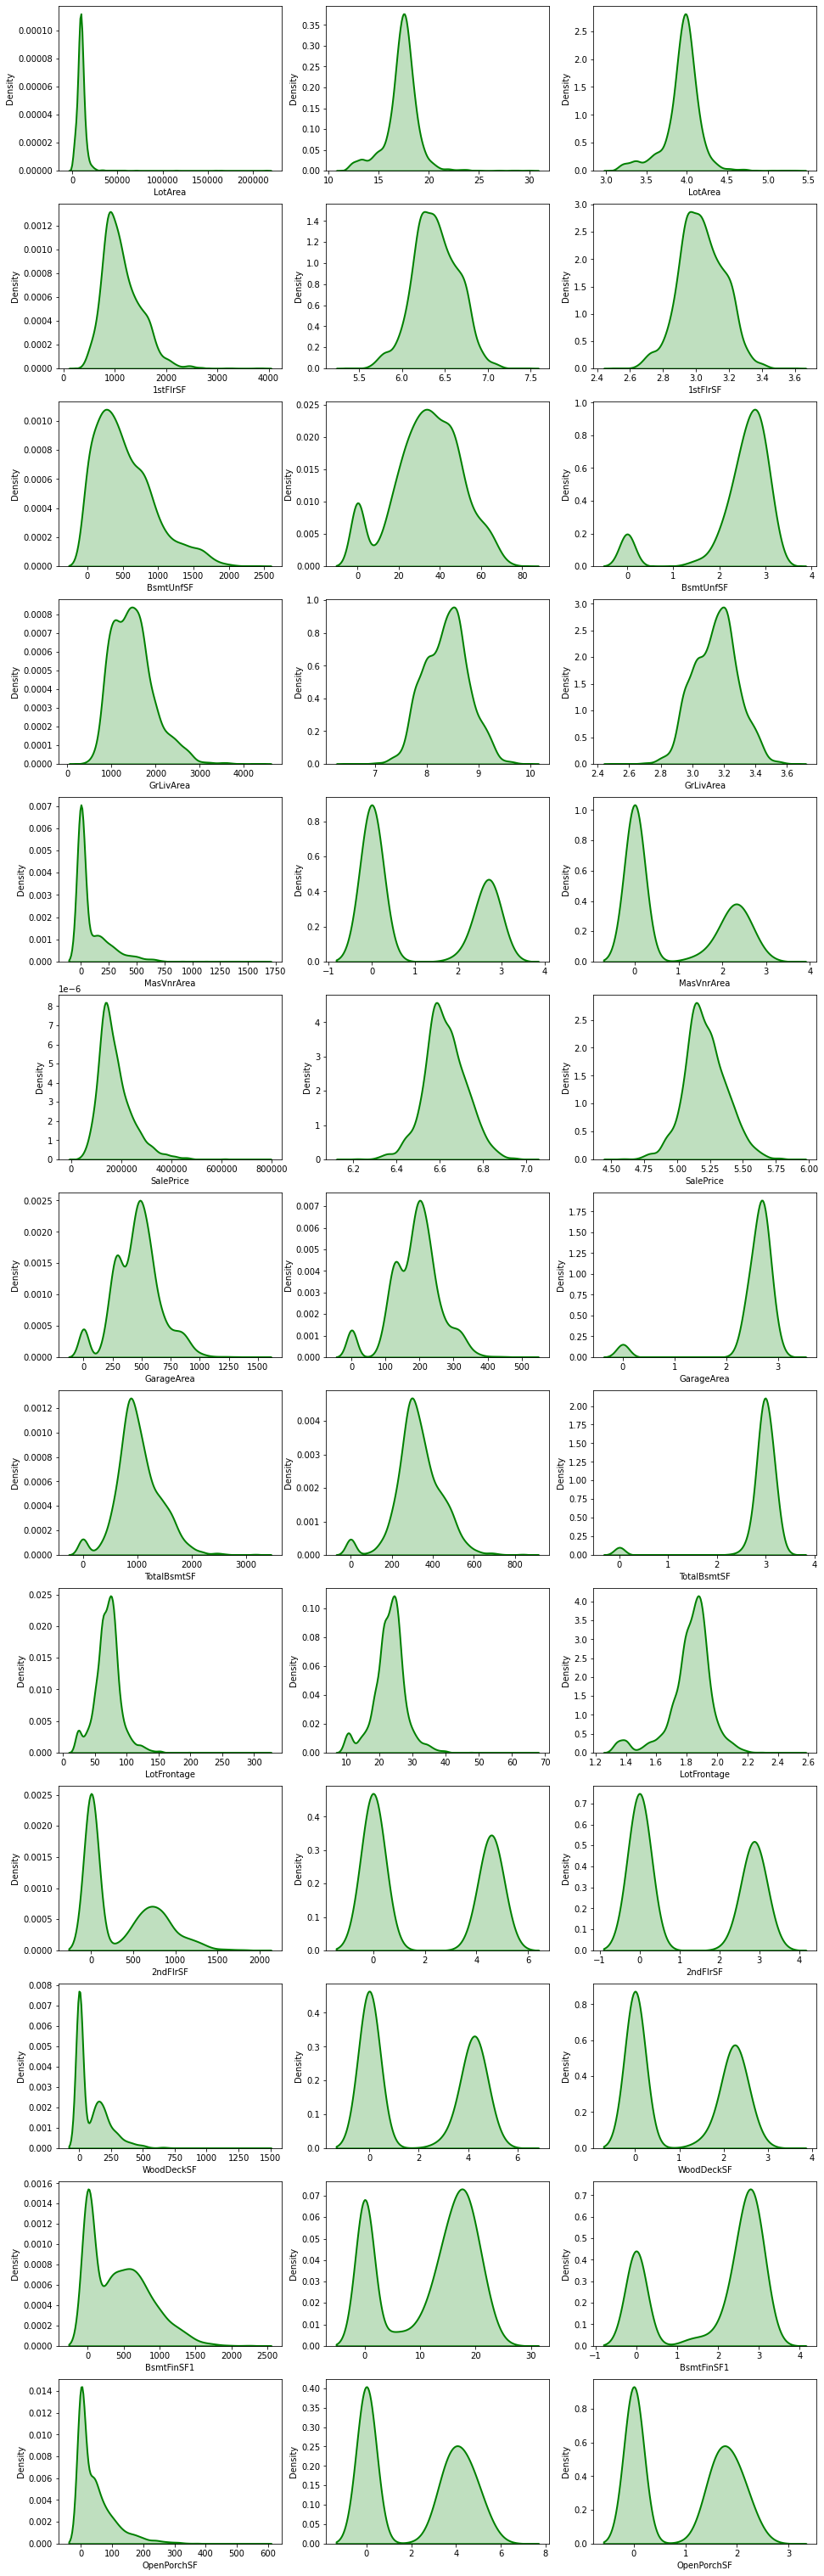

In [22]:
# creating axes to draw plots: 3 plots per feature
fig, ax = plt.subplots(dataset_encoded[continuous_variables_updated].shape[1], 3,  figsize=(16,55))
# Plot original data, boxcox, and log10
for i,feature in enumerate(continuous_variables_updated):
    original_data = dataset_encoded[feature]+1
    sns.distplot(original_data, hist = False, kde = True, 
                kde_kws = {'shade': True, 'linewidth': 2},  
                label = "Original", color ="green", ax = ax[i,0]) 

    fitted_data, fitted_lambda = stats.boxcox(original_data) 
    sns.distplot(fitted_data, hist = False, kde = True, 
                kde_kws = {'shade': True, 'linewidth': 2},  
                label = "Boxcox", color ="green", ax = ax[i,1]) 

    sns.distplot(np.log10(original_data), hist = False, kde = True, 
                kde_kws = {'shade': True, 'linewidth': 2},  
                label = "Log10", color ="green", ax = ax[i,2])

<b>Conclusion:</b> we will take the log10 of the following features: 1stFirSF, GrLivArea, and LotArea

In [23]:
# Take log10 of GrLivArea, LotArea, and 1stFlrSF
dataset_encoded['log10_GrLivArea'] = np.log10(dataset_encoded['GrLivArea'])
dataset_encoded['log10_LotArea'] = np.log10(dataset_encoded['LotArea'])
dataset_encoded['log10_1stFlrSF'] = np.log10(dataset_encoded['1stFlrSF']+1)     # +1 : This means we are adding bias, but is needed for zero
# Remove original columns
dataset_encoded.drop(columns=['GrLivArea','LotArea','1stFlrSF'], inplace=True)

<br><br>
<hr style="height:1px;border:none;color:#333;background-color:#333;" />

### 1.3 Feature Selection<a class="anchor" id="fs"></a>

#### 1.3.1 Using Lasso Regression to Select Features<a class="anchor" id="lasso"></a>

In [24]:
X = dataset_encoded.drop('SalePrice',axis=1)  # features
y = dataset_encoded['SalePrice']              # target
X_norm = MinMaxScaler().fit_transform(X)      # Transform features by scaling each feature to a given range (0,1).

In [25]:
# Using Lasso to select features
clf = LassoCV(alphas=np.arange(0.0001, 0.01)).fit(X_norm, y)   # set alpha low to ensure the features will have more relevance
importance = np.abs(clf.coef_)

In [26]:
# create dataframe Feature - Importance
features =[]
scores = []
for i, feature in enumerate(X.columns):
    if importance[i]>0:
        features.append(feature)
        scores.append(importance[i])
# dataframe
feature_score = pd.DataFrame.from_dict({"feature":features,"Score":scores})

In [27]:
# top 20 features with highest importance value
lasso_generated_features = list(feature_score.sort_values(by="Score", ascending=False).head(20)['feature'])

<br><br>
<hr style="height:1px;border:none;color:#333;background-color:#333;" />

### 1.4 Descriptive Modeling<a class="anchor" id="dm"></a>

#### 1.4.1 Train and Test data<a class="anchor" id="ttd"></a>

In [28]:
# dataset -> Includes all features - Ordinal features encoded, Nominal features not dummified.
# dataset_encoded.shape -> Includes all features - Ordinal and Nominal features encoded/dummified.
# X -> Same as dataset_encoded without SalePrice feature
# Y -> Same as dataset_encoded but only SalePrice feature
# X_norm -> Same as X but all the numerical values scaled (0,1)

In [29]:
# Split data 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=10)

#### 1.4.2 Multiple Linear Regression with all the features<a class="anchor" id="mlr"></a>

In [30]:
# Create model: Multiple Linear Regression
mlr_model = LinearRegression()
mlr_model.fit(X_train,np.log(y_train))

LinearRegression()

In [31]:
# # Calculate R-squared (score) using Training data
mlr_model.score(X_train,np.log(y_train))

0.9596248164084863

In [32]:
# Calculate R-squared (score) using Test data
mlr_model.score(X_test,np.log(y_test))

0.9353804149586097

#### 1.4.3 Multiple Linear Regresion with limited number of features<a class="anchor" id="mlr2"></a>

In [33]:
# Fit model with training data using Lasso generated features (top 20)
mlr_model.fit(X_train[lasso_generated_features], np.log10(y_train))
# Calculate R-squared (score) using training data
mlr_model.score(X_train[lasso_generated_features], np.log10(y_train))

0.9209162955514257

In [34]:
# Calculate R-squared (score) using test data
mlr_model.score(X_test[lasso_generated_features], np.log10(y_test))

0.9182176601933647

In [35]:
# Coefficients for features
for i, name_c in enumerate(lasso_generated_features):
    print(name_c +":  " + "{:.6f}". format(mlr_model.coef_[i]))

log10_1stFlrSF:  0.230083
TotalBsmtSF:  0.000079
Condition2_PosA:  0.043557
2ndFlrSF:  0.000081
Neighborhood_GrnHill:  0.164508
log10_LotArea:  0.109813
OverallQual:  0.037370
RoofMatl_WdShngl:  0.004379
Condition2_PosN:  0.050021
MasVnrArea:  0.000027
GarageType_None:  -0.028972
YearBuilt:  0.001531
log10_GrLivArea:  0.221022
OverallCond:  0.022255
Exterior2nd_PreCast:  0.175791
Heating_OthW:  -0.044454
BsmtUnfSF:  -0.000041
BsmtCond:  0.006394
Condition2_RRAn:  0.000000
BedroomAbvGr:  -0.014778


#### 1.4.4 Evaluating p-values and R-squared using Statmodels<a class="anchor" id="statmodel"></a>

In [36]:
# Statmodels does not like feature names starting with a number
X_stat = dataset_encoded.rename(columns={'2ndFlrSF':'FlrSF2nd'})
y_stat = dataset['SalePrice']
# Split data 70/30
X_train_stat, X_test_stat, y_train_stat, y_test_stat = train_test_split(X_stat, y_stat, test_size=0.30, random_state=10)
smf_model_features = lasso_generated_features
smf_model_features[3] = 'FlrSF2nd'

In [37]:
# Fit regression model (using the natural log of one of the regressors)
results = smf.ols('np.log10(SalePrice) ~ ' + ' + '.join(smf_model_features), data=X_train_stat).fit()

# Inspect the results
print(results.summary())

                             OLS Regression Results                            
Dep. Variable:     np.log10(SalePrice)   R-squared:                       0.921
Model:                             OLS   Adj. R-squared:                  0.920
Method:                  Least Squares   F-statistic:                     1023.
Date:                 Sat, 28 Nov 2020   Prob (F-statistic):               0.00
Time:                         09:41:51   Log-Likelihood:                 2802.7
No. Observations:                 1689   AIC:                            -5565.
Df Residuals:                     1669   BIC:                            -5457.
Df Model:                           19                                         
Covariance Type:             nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             

In [38]:
# Decided to remove the following features whose Statistical Significance is low and some of the nominal features
smf_model_features = set(lasso_generated_features) - set(['Condition2_PosA','RoofMatl_WdShngl',
                                                          'Condition2_PosN','Heating_OthW','Condition2_RRAn'])#,'BsmtCond'])
                                                          #'Neighborhood_GrnHill','Exterior1st_PreCast','GarageType_None']) 

In [39]:
# Let's try again
# Fit regression model (using the natural log of one of the regressors)
results = smf.ols('np.log10(SalePrice) ~ ' + ' + '.join(smf_model_features), data=X_train_stat).fit()

# Inspect the results
print(results.summary())

                             OLS Regression Results                            
Dep. Variable:     np.log10(SalePrice)   R-squared:                       0.921
Model:                             OLS   Adj. R-squared:                  0.920
Method:                  Least Squares   F-statistic:                     1295.
Date:                 Sat, 28 Nov 2020   Prob (F-statistic):               0.00
Time:                         09:41:51   Log-Likelihood:                 2800.2
No. Observations:                 1689   AIC:                            -5568.
Df Residuals:                     1673   BIC:                            -5482.
Df Model:                           15                                         
Covariance Type:             nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             

#### 1.4.5 Further narrowing of the number of features<a class="anchor" id="fnnf"></a>

In [45]:
import itertools

In [46]:
%%time
scores_models = {}
for features in itertools.combinations(smf_model_features, len(smf_model_features)-7):
    results = smf.ols('np.log10(SalePrice) ~ ' + ' + '.join(features), data=X_train_stat).fit()
    scores_models[features] = results.rsquared_adj

Wall time: 1min


In [47]:
Keymax = max(scores_models, key=scores_models.get) 
print(Keymax)

('log10_LotArea', 'log10_GrLivArea', 'BsmtUnfSF', 'OverallCond', 'BedroomAbvGr', 'TotalBsmtSF', 'YearBuilt', 'OverallQual')


In [43]:
scores_models[('BsmtUnfSF', 'TotalBsmtSF', 'log10_GrLivArea', 'BedroomAbvGr', 'OverallQual', 'OverallCond', 'YearBuilt', 'log10_LotArea')]

KeyError: ('BsmtUnfSF', 'TotalBsmtSF', 'log10_GrLivArea', 'BedroomAbvGr', 'OverallQual', 'OverallCond', 'YearBuilt', 'log10_LotArea')

In [48]:
# Let's try again
results = smf.ols('np.log10(SalePrice) ~ ' + ' + '.join(['log10_GrLivArea', 'YearBuilt', 'TotalBsmtSF', 'log10_LotArea', 'BsmtUnfSF', 'OverallCond', 'OverallQual']), data=dataset_encoded).fit()
# Inspect the results
print(results.summary())

                             OLS Regression Results                            
Dep. Variable:     np.log10(SalePrice)   R-squared:                       0.911
Model:                             OLS   Adj. R-squared:                  0.910
Method:                  Least Squares   F-statistic:                     3506.
Date:                 Sat, 28 Nov 2020   Prob (F-statistic):               0.00
Time:                         09:44:18   Log-Likelihood:                 3898.0
No. Observations:                 2413   AIC:                            -7780.
Df Residuals:                     2405   BIC:                            -7734.
Df Model:                            7                                         
Covariance Type:             nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.1811      

<br><br>
<hr style="height:1px;border:none;color:#333;background-color:#333;" />

### 1.5 Evaluating Overall Quality, Fence, and Roof<a class="anchor" id="eval-section"></a>

In [49]:
# 'OverallQual', 'OverallCond', 'PavedDrive', 'Fence','RoofStyle', 'RoofMatl'

#### 1.5.1 Roof Material<a class="anchor" id="roof-material"></a>

<h4>Roof material</h4>
<p>&nbsp;</p>
<table style="border-collapse: collapse; width: 46.0227%; height: 162px;" border="1">
<thead>
<tr style="border-style: ridge; height: 18px;">
<td style="width: 3.50375%; height: 18px; border-style: ridge;">Abbreviation</td>
<td style="width: 9.18553%; height: 18px; border-style: ridge;">Material</td>
</tr>
</thead>
<tbody>
<tr style="height: 18px;">
<td style="width: 3.50375%; height: 18px; border-style: ridge;">ClyTile</td>
<td style="width: 9.18553%; height: 18px; border-style: ridge;">Clay or Tile</td>
</tr>
<tr style="height: 18px;">
<td style="width: 3.50375%; height: 18px; border-style: ridge;">CompShg</td>
<td style="width: 9.18553%; height: 18px; border-style: ridge;">Standard (Composite) Shingle</td>
</tr>
<tr style="height: 18px;">
<td style="width: 3.50375%; height: 18px; border-style: ridge;">Membran</td>
<td style="width: 9.18553%; height: 18px; border-style: ridge;">Membrane</td>
</tr>
<tr style="height: 18px;">
<td style="width: 3.50375%; height: 18px; border-style: ridge;">Metal</td>
<td style="width: 9.18553%; height: 18px; border-style: ridge;">Metal</td>
</tr>
<tr style="height: 18px;">
<td style="width: 3.50375%; height: 18px; border-style: ridge;">Roll</td>
<td style="width: 9.18553%; height: 18px; border-style: ridge;">Roll</td>
</tr>
<tr style="height: 18px;">
<td style="width: 3.50375%; height: 18px; border-style: ridge;">Tar&amp;Grv</td>
<td style="width: 9.18553%; height: 18px; border-style: ridge;">Gravel &amp; Tar</td>
</tr>
<tr style="height: 18px;">
<td style="width: 3.50375%; height: 18px; border-style: ridge;">WdShake</td>
<td style="width: 9.18553%; height: 18px; border-style: ridge;">Wood Shakes</td>
</tr>
<tr style="height: 18px;">
<td style="width: 3.50375%; height: 18px; border-style: ridge;">WdShngl</td>
<td style="width: 9.18553%; height: 18px; border-style: ridge;">Wood Shingles</td>
</tr>
</tbody>
</table>

In [50]:
roof_matl_dict = ({"ClyTile":"Clay or Tile","CompShg":"Standard (Composite) Shingle","Membran":"Membrane",
                   "Metal":"Metal","Roll":"Roll","Tar&Grv":"Gravel & Tar","WdShake":"Wood Shakes",
                   "WdShngl":"Wood Shingles",})

In [51]:
roofmatl_count = dataset.groupby(['RoofMatl']).agg({"RoofMatl":"count"})/dataset.shape[0]*100
roofmatl_count.columns = ['Number of Houses']
roofmatl_count.reset_index(inplace=True)
roofmatl_count.columns=["Roof Material",'Percentage of Houses']
roofmatl_count['Roof Material'].replace(roof_matl_dict, inplace=True)

In [52]:
roofmatl_count.style.applymap(lambda x: 'color: red' if (x<0.05) else 'color: black', subset=['Percentage of Houses']).hide_index()

Roof Material,Percentage of Houses
Standard (Composite) Shingle,98.673850
Membrane,0.041442
Metal,0.041442
Roll,0.041442
Gravel & Tar,0.621633
Wood Shakes,0.290095
Wood Shingles,0.290095


<ul>
<li>Not enough houses have <span style="color: #ff0000;">Metal</span>, <span style="color: #ff0000;">Roll</span>, or <span style="color: #ff0000;">Membrane</span> as Roof Material to evaluate them. It is not possible to see a pattern to determine if these roof materials would add or subtract value from the base price of the house.</li>
<li>Most houses have Standard (Composite) Shingle as the roofing material.</li>
</ul>

We are going to evaluate how much the sale price of the house changes when the roof material is replaced with Grave & Tar, Wood Shakes or Wood Shingles.

In [53]:
dataset.groupby(['RoofMatl']).agg({"RoofMatl":"count"})

,RoofMatl
RoofMatl,
CompShg,2381
Membran,1
Metal,1
Roll,1
Tar&Grv,15
WdShake,7
WdShngl,7


In [54]:
#dataset[(dataset['RoofMatl']=='CompShg') & (dataset['SalePrice']>270000) & (dataset['SalePrice']<290001)].sort_values(by='SalePrice') #.unique()

In [55]:
dataset[dataset['RoofMatl']=='WdShngl'].sort_values(by='SalePrice') #.unique()

,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,Fence,MoSold,YrSold,SaleType,BsmtNumBath,TotalNumBath
2190,1350,168500,80,RL,82.0,9020,Pave,4,Lvl,4,Corner,3,NAmes,Feedr,Norm,1Fam,SLvl,6,5,1964,1964,Gable,WdShngl,Plywood,Wd Sdng,BrkFace,259.0,3,3,CBlock,3,3,4,6,624.0,3,288.0,1248.0,GasA,3,Y,5,1350,0,3,1,3,6,8,0,0,Attchd,1964.0,2,2.0,520.0,3,3,3,176,0,4,6,2008,WD,1.0,1.5
538,2524,278000,20,RL,80.0,9600,Pave,4,Lvl,4,Inside,3,NWAmes,PosN,Norm,1Fam,1Story,8,5,1981,1981,Hip,WdShngl,BrkFace,BrkFace,None,0.0,4,3,PConc,4,3,1,5,1104.0,1,1420.0,2524.0,GasA,3,Y,5,2524,0,4,1,4,9,8,1,4,Attchd,1981.0,3,2.0,542.0,3,3,3,474,120,3,7,2009,WD,1.0,2.5
1626,1743,279000,20,RL,155.0,20064,Pave,3,Low,4,Inside,1,ClearCr,Norm,Norm,1Fam,1Story,8,6,1976,1976,Shed,WdShngl,Wd Sdng,Wd Sdng,None,0.0,4,3,CBlock,4,4,4,2,51.0,6,0.0,966.0,GasA,5,Y,5,1743,0,0,1,4,5,8,2,2,Attchd,1976.0,3,2.0,529.0,3,3,3,646,0,0,5,2007,WD,2.0,0.5
1954,1533,280000,20,RL,62.0,70761,Pave,3,Low,4,Inside,2,ClearCr,Norm,Norm,1Fam,1Story,7,5,1975,1975,Gable,WdShngl,Plywood,Plywood,None,0.0,3,3,CBlock,4,3,4,5,655.0,1,878.0,1533.0,GasA,3,Y,5,1533,0,2,1,4,5,8,2,3,Attchd,1975.0,1,2.0,576.0,3,3,3,200,54,0,12,2006,WD,1.0,2.0
347,1842,385000,20,RL,68.0,50271,Pave,3,Low,4,Inside,3,Veenker,Norm,Norm,1Fam,1Story,9,5,1981,1987,Gable,WdShngl,WdShing,Wd Shng,None,0.0,4,3,CBlock,5,3,4,6,1810.0,1,32.0,1842.0,GasA,4,Y,5,1842,0,0,1,4,5,8,1,4,Attchd,1981.0,3,3.0,894.0,3,3,3,857,72,0,11,2006,WD,2.0,0.5
2003,3608,475000,75,RM,90.0,22950,Pave,2,Lvl,4,Inside,3,OldTown,Artery,Norm,1Fam,2.5Fin,10,9,1892,1993,Gable,WdShngl,Wd Sdng,Wd Sdng,None,0.0,4,4,BrkTil,3,3,2,1,0.0,1,1107.0,1107.0,GasA,5,Y,5,1518,1518,4,1,5,12,8,2,3,Detchd,1993.0,1,3.0,840.0,5,3,3,0,260,4,6,2006,WD,0.0,2.5
1007,4316,755000,60,RL,104.0,21535,Pave,3,Lvl,4,Corner,3,NoRidge,Norm,Norm,1Fam,2Story,10,6,1994,1995,Gable,WdShngl,HdBoard,HdBoard,BrkFace,1170.0,5,3,PConc,5,3,4,6,1455.0,1,989.0,2444.0,GasA,5,Y,5,2444,1872,4,1,5,10,8,2,5,Attchd,1994.0,3,3.0,832.0,3,3,3,382,50,0,1,2007,WD,0.5,3.5


In [56]:
dataset_encoded[['OverallQual', 'BedroomAbvGr', 'log10_GrLivArea', 'OverallCond',
                                      'YearBuilt', 'BsmtUnfSF', 'TotalBsmtSF','SalePrice',
                                      'log10_LotArea']]

,OverallQual,BedroomAbvGr,log10_GrLivArea,OverallCond,YearBuilt,BsmtUnfSF,TotalBsmtSF,SalePrice,log10_LotArea
0,6,2,2.932474,6,1939,618.0,856.0,126000,3.897077
1,5,2,3.020775,5,1984,104.0,1049.0,139500,3.626853
2,5,2,3.000434,9,1930,100.0,837.0,124900,3.782473
3,4,2,3.016616,8,1900,405.0,405.0,114000,3.910944
4,8,3,3.221414,6,2001,167.0,810.0,227000,3.924279
...,...,...,...,...,...,...,...,...,...
2574,6,2,2.978637,6,1916,952.0,952.0,121000,3.947140
2575,3,4,3.238799,5,1955,0.0,0.0,139600,4.136086
2576,5,4,3.301464,6,1949,717.0,1001.0,145000,3.797268
2577,7,3,3.265290,5,2000,144.0,985.0,217500,3.945764


In [57]:
df_roof = pd.concat([dataset_encoded[['OverallQual', 'BedroomAbvGr', 'log10_GrLivArea', 'OverallCond',
                                      'YearBuilt', 'BsmtUnfSF', 'TotalBsmtSF','SalePrice',
                                      'log10_LotArea']],pd.get_dummies(dataset['RoofMatl'])], axis=1)

In [58]:
# Remove observations for houses with Metal, Membran or Roll. (One house for each)
df_roof.drop(index=df_roof[(df_roof['Metal']==1)].index[0], inplace=True)
df_roof.drop(index=df_roof[(df_roof['Membran']==1)].index[0], inplace=True)
df_roof.drop(index=df_roof[(df_roof['Roll']==1)].index[0], inplace=True)
df_roof.drop(columns=['Membran','Metal','Roll'], inplace=True)

In [59]:
df_roof.rename(columns={"Tar&Grv":"TarGrv"}, inplace=True)

In [60]:
# Model to evaluate roof material
mlr_model_roof = LinearRegression()
mlr_model_roof.fit(df_roof.drop(columns=['SalePrice']), np.log10(df_roof['SalePrice']))
mlr_model_roof.score(df_roof.drop(columns=['SalePrice']), np.log10(df_roof['SalePrice']))

0.9137925342245923

In [61]:
df_roof

,OverallQual,BedroomAbvGr,log10_GrLivArea,OverallCond,YearBuilt,BsmtUnfSF,TotalBsmtSF,SalePrice,log10_LotArea,CompShg,TarGrv,WdShake,WdShngl
0,6,2,2.932474,6,1939,618.0,856.0,126000,3.897077,1,0,0,0
1,5,2,3.020775,5,1984,104.0,1049.0,139500,3.626853,1,0,0,0
2,5,2,3.000434,9,1930,100.0,837.0,124900,3.782473,1,0,0,0
3,4,2,3.016616,8,1900,405.0,405.0,114000,3.910944,1,0,0,0
4,8,3,3.221414,6,2001,167.0,810.0,227000,3.924279,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2574,6,2,2.978637,6,1916,952.0,952.0,121000,3.947140,1,0,0,0
2575,3,4,3.238799,5,1955,0.0,0.0,139600,4.136086,1,0,0,0
2576,5,4,3.301464,6,1949,717.0,1001.0,145000,3.797268,1,0,0,0
2577,7,3,3.265290,5,2000,144.0,985.0,217500,3.945764,1,0,0,0


In [62]:
# Predict the sale price of a house with different roof materials
# df_roof[df_roof['CompShg']==1].head(10).drop(columns=['SalePrice'])#,'TarGrv','WdShake','WdShngl'])
houses_to_predict = df_roof[df_roof['CompShg']==1].head(4)
mlr_model_roof.predict(houses_to_predict.drop(columns=['SalePrice']))

array([5.05385153, 5.11549829, 5.11652676, 4.97707169])

In [63]:
houses_to_predict

,OverallQual,BedroomAbvGr,log10_GrLivArea,OverallCond,YearBuilt,BsmtUnfSF,TotalBsmtSF,SalePrice,log10_LotArea,CompShg,TarGrv,WdShake,WdShngl
0,6,2,2.932474,6,1939,618.0,856.0,126000,3.897077,1,0,0,0
1,5,2,3.020775,5,1984,104.0,1049.0,139500,3.626853,1,0,0,0
2,5,2,3.000434,9,1930,100.0,837.0,124900,3.782473,1,0,0,0
3,4,2,3.016616,8,1900,405.0,405.0,114000,3.910944,1,0,0,0


In [64]:
print(10**5.05385153)
print(10**5.11549829)
print(10**5.11652676)
print(10**4.97707169)

113201.33015670952
130466.28316235903
130775.61166779378
94857.50338643852


In [65]:
houses_to_predict['CompShg']=0
houses_to_predict['TarGrv']=1

In [66]:
houses_to_predict

,OverallQual,BedroomAbvGr,log10_GrLivArea,OverallCond,YearBuilt,BsmtUnfSF,TotalBsmtSF,SalePrice,log10_LotArea,CompShg,TarGrv,WdShake,WdShngl
0,6,2,2.932474,6,1939,618.0,856.0,126000,3.897077,0,1,0,0
1,5,2,3.020775,5,1984,104.0,1049.0,139500,3.626853,0,1,0,0
2,5,2,3.000434,9,1930,100.0,837.0,124900,3.782473,0,1,0,0
3,4,2,3.016616,8,1900,405.0,405.0,114000,3.910944,0,1,0,0


In [67]:
mlr_model_roof.predict(houses_to_predict.drop(columns=['SalePrice']))

array([5.05946811, 5.12111487, 5.12214335, 4.98268828])

In [68]:
# log10(y) = beta0 + beta1*X1 + beta2*log10(X2) + beta2*X3
print(10**5.05946811)
print(10**5.12111487)
print(10**5.12214335)
print(10**4.98268828)

114674.83132459615
132164.51603951218
132477.8740137215
96092.23174430412


In [69]:
houses_to_predict['TarGrv']=0
houses_to_predict['WdShake']=1

In [70]:
mlr_model_roof.predict(houses_to_predict.drop(columns=['SalePrice']))

array([5.03706615, 5.09871291, 5.09974138, 4.96028631])

In [71]:
print(10**5.03706615)
print(10**5.09871291)
print(10**5.09974138)
print(10**4.96028631)

108909.59674460991
125519.99405228219
125817.595173593
91261.22835938397


In [72]:
houses_to_predict['WdShake']=0
houses_to_predict['WdShngl']=1

In [73]:
mlr_model_roof.predict(houses_to_predict.drop(columns=['SalePrice']))

array([5.07892685, 5.14057361, 5.14160208, 5.00214701])

In [74]:
print(10**5.07892685)
print(10**5.14057361)
print(10**5.14160208)
print(10**5.00214701)

119929.72835783094
138220.86611400277
138548.58031646637
100495.59133350274


#### 1.5.2 Fence Quality<a class="anchor" id="fence-quality"></a>

<p><strong>Fence Quality</strong></p>
<table style="border-collapse: collapse; width: 44.472%; height: 103px;" border="1">
<thead>
<tr style="height: 18px;">
<td style="width: 8.16763%; border-style: ridge; text-align: center;"><em><strong>Rating</strong></em></td>
<td style="width: 8.26072%; height: 18px; border-style: ridge; text-align: center;"><em><strong>Quality</strong></em></td>
<td style="width: 38.401%; height: 18px; border-style: ridge; text-align: center;"><em><strong>Description</strong></em></td>
</tr>
</thead>
<tbody>
<tr style="height: 18px;">
<td style="width: 8.16763%; border-style: ridge; text-align: center;">4</td>
<td style="width: 8.26072%; height: 18px; border-style: ridge; text-align: center;">GdPrv</td>
<td style="width: 38.401%; height: 18px; border-style: ridge; text-align: left;">&nbsp; Good Privacy</td>
</tr>
<tr style="height: 18px;">
<td style="width: 8.16763%; border-style: ridge; text-align: center;">3</td>
<td style="width: 8.26072%; height: 18px; border-style: ridge; text-align: center;">MnPrv</td>
<td style="width: 38.401%; height: 18px; border-style: ridge; text-align: left;">&nbsp; Minimum Privacy</td>
</tr>
<tr style="height: 18px;">
<td style="width: 8.16763%; border-style: ridge; text-align: center;">2</td>
<td style="width: 8.26072%; height: 18px; border-style: ridge; text-align: center;">GdWo</td>
<td style="width: 38.401%; height: 18px; border-style: ridge; text-align: left;">&nbsp; Good Wood</td>
</tr>
<tr style="height: 13px;">
<td style="width: 8.16763%; border-style: ridge; text-align: center;">1</td>
<td style="width: 8.26072%; height: 13px; border-style: ridge; text-align: center;">MnWw</td>
<td style="width: 38.401%; height: 13px; border-style: ridge; text-align: left;">&nbsp; Minimum Wood/Wire</td>
</tr>
<tr style="height: 18px;">
<td style="width: 8.16763%; border-style: ridge; text-align: center;">0</td>
<td style="width: 8.26072%; height: 18px; border-style: ridge; text-align: center;">NA</td>
<td style="width: 38.401%; height: 18px; border-style: ridge; text-align: left;">&nbsp; No Fence</td>
</tr>
</tbody>
</table>

In [75]:
df_fence = (dataset.groupby('Fence').agg(count=pd.NamedAgg(column="Fence", aggfunc="count"))/dataset.shape[0]*100).reset_index()
df_fence.columns=['Fence Rating','Percentage of Houses']
df_fence.style.hide_index()

Fence Rating,Percentage of Houses
0,79.196022
1,0.414422
2,4.102777
3,11.852466
4,4.434314


In [76]:
dataset['CostSquareFoot'] = dataset['SalePrice'] / dataset['GrLivArea']

In [77]:
dataset.groupby('Fence').agg({"CostSquareFoot":"mean"})

,CostSquareFoot
Fence,
0,121.058243
1,116.196454
2,117.450462
3,116.691940
4,117.182585


In [78]:
(dataset.groupby('Fence').agg({"Fence":"mean"))/dataset.shape[0]*100).reset_index()

SyntaxError: closing parenthesis ')' does not match opening parenthesis '{' (<ipython-input-78-26c6dfd14328>, line 1)

In [79]:
df_fence = dataset_encoded[['OverallQual', 'BedroomAbvGr', 'log10_GrLivArea', 'OverallCond',
           'YearBuilt', 'BsmtUnfSF', 'TotalBsmtSF','SalePrice','log10_LotArea','Fence']]

In [80]:
df_fence = pd.concat([dataset_encoded[['OverallQual', 'BedroomAbvGr', 'log10_GrLivArea', 'OverallCond',
                                      'YearBuilt', 'BsmtUnfSF', 'TotalBsmtSF','SalePrice',
                                      'log10_LotArea']],pd.get_dummies(dataset['Fence'])], axis=1)

In [81]:
# Model to evaluate roof material
mlr_model_fence = LinearRegression()
mlr_model_fence.fit(df_fence.drop(columns=['SalePrice']), np.log10(df_fence['SalePrice']))
mlr_model_fence.score(df_fence.drop(columns=['SalePrice']), np.log10(df_fence['SalePrice']))

0.9137509434084412

In [82]:
df_fence_test = df_fence.head(5)

In [83]:
df_fence_test

,OverallQual,BedroomAbvGr,log10_GrLivArea,OverallCond,YearBuilt,BsmtUnfSF,TotalBsmtSF,SalePrice,log10_LotArea,0,1,2,3,4
0,6,2,2.932474,6,1939,618.0,856.0,126000,3.897077,1,0,0,0,0
1,5,2,3.020775,5,1984,104.0,1049.0,139500,3.626853,1,0,0,0,0
2,5,2,3.000434,9,1930,100.0,837.0,124900,3.782473,1,0,0,0,0
3,4,2,3.016616,8,1900,405.0,405.0,114000,3.910944,1,0,0,0,0
4,8,3,3.221414,6,2001,167.0,810.0,227000,3.924279,1,0,0,0,0


In [84]:
for i in mlr_model_fence.predict(df_fence_test.drop(columns=['SalePrice'])):
    print(10**i)

113509.42525960298
130639.6794187083
131210.90711025996
95156.30261686118
239329.52720840523


In [85]:
df_fence_test

,OverallQual,BedroomAbvGr,log10_GrLivArea,OverallCond,YearBuilt,BsmtUnfSF,TotalBsmtSF,SalePrice,log10_LotArea,0,1,2,3,4
0,6,2,2.932474,6,1939,618.0,856.0,126000,3.897077,1,0,0,0,0
1,5,2,3.020775,5,1984,104.0,1049.0,139500,3.626853,1,0,0,0,0
2,5,2,3.000434,9,1930,100.0,837.0,124900,3.782473,1,0,0,0,0
3,4,2,3.016616,8,1900,405.0,405.0,114000,3.910944,1,0,0,0,0
4,8,3,3.221414,6,2001,167.0,810.0,227000,3.924279,1,0,0,0,0


In [86]:
df_fence_test[0]=0
df_fence_test[1]=1
for i in mlr_model_fence.predict(df_fence_test.drop(columns=['SalePrice'])):
    print(10**i)

109381.82476359696
125889.16284853379
126439.61869935427
91696.08597862895
230626.66686923066


In [87]:
df_fence_test[1]=0
df_fence_test[2]=1
for i in mlr_model_fence.predict(df_fence_test.drop(columns=['SalePrice'])):
    print(10**i)

112713.85929255496
129724.05075920369
130291.27482453847
94489.37019482697
237652.11208343884


In [88]:
df_fence_test[2]=0
df_fence_test[3]=1
for i in mlr_model_fence.predict(df_fence_test.drop(columns=['SalePrice'])):
    print(10**i)

112782.42948460355
129802.96920924798
130370.53834894484
94546.85340320504
237796.68925494724


In [89]:
df_fence_test[3]=0
df_fence_test[4]=1
for i in mlr_model_fence.predict(df_fence_test.drop(columns=['SalePrice'])):
    print(10**i)

113394.37192387009
130507.2628298495
131077.91152409566
95059.85203571305
239086.942415277


#### 1.5.3 Overall Quality of the House<a class="anchor" id="overall-quality"></a>

In [90]:
dataset['OverallQual'].value_counts()

5     715
6     640
7     493
8     256
4     185
9      64
3      32
10     15
2      10
1       3
Name: OverallQual, dtype: int64

<br><br><br><br>

<hr>

#### Linear Model

<b>Ava: </b>'BsmtQual', 'BsmtCond','BsmtFinType1', 'BsmtFinType1', 'BsmtUnfSF', 'TotalBsmtSF'

<b>Khamanna: </b>'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'GarageFinish', GarageQual', 'GarageCond',

<b>Ariel:</b>'OverallQual', 'OverallCond', 'PavedDrive', 'Fence', 'RoofStyle', 'RoofMatl',

<b>Shay: </b>'HeatingQC', 'CentralAir', 'KitchenAbvGr', 'KitchenQual', 'Fireplaces', 'FireplaceQu', 'LowQualFinSF'
 
y = beta0 + beta1*X1 + beta2*X2 + beta3*X3 + beta4*X4 ...+ betan*Xn(Exterior Quality)

1) Garage -> 'GarageFinish', 'GarageQual', 'GarageCond'
2) Exterior -> 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd'

1) Basement -> 'BsmtQual', 'BsmtCond','BsmtFinType1', 'BsmtFinType1', 'BsmtUnfSF', 'TotalBsmtSF'
2) 'Fireplaces', 'FireplaceQu', 

1) Overall Condition -> 'OverallQual', 'OverallCond', 
2) RoofStyle, RoofMatl

1) AC -> 'HeatingQC', 'CentralAir'
2) 'KitchenAbvGr', 'KitchenQual'
3) 'LowQualFinSF'

In [91]:
dataset['']#.value_counts()

KeyError: ''

In [92]:
dataset[dataset['RoofMatl']=="WdShngl"]

,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,Fence,MoSold,YrSold,SaleType,BsmtNumBath,TotalNumBath,CostSquareFoot
347,1842,385000,20,RL,68.0,50271,Pave,3,Low,4,Inside,3,Veenker,Norm,Norm,1Fam,1Story,9,5,1981,1987,Gable,WdShngl,WdShing,Wd Shng,None,0.0,4,3,CBlock,5,3,4,6,1810.0,1,32.0,1842.0,GasA,4,Y,5,1842,0,0,1,4,5,8,1,4,Attchd,1981.0,3,3.0,894.0,3,3,3,857,72,0,11,2006,WD,2.0,0.5,209.011944
538,2524,278000,20,RL,80.0,9600,Pave,4,Lvl,4,Inside,3,NWAmes,PosN,Norm,1Fam,1Story,8,5,1981,1981,Hip,WdShngl,BrkFace,BrkFace,None,0.0,4,3,PConc,4,3,1,5,1104.0,1,1420.0,2524.0,GasA,3,Y,5,2524,0,4,1,4,9,8,1,4,Attchd,1981.0,3,2.0,542.0,3,3,3,474,120,3,7,2009,WD,1.0,2.5,110.142631
1007,4316,755000,60,RL,104.0,21535,Pave,3,Lvl,4,Corner,3,NoRidge,Norm,Norm,1Fam,2Story,10,6,1994,1995,Gable,WdShngl,HdBoard,HdBoard,BrkFace,1170.0,5,3,PConc,5,3,4,6,1455.0,1,989.0,2444.0,GasA,5,Y,5,2444,1872,4,1,5,10,8,2,5,Attchd,1994.0,3,3.0,832.0,3,3,3,382,50,0,1,2007,WD,0.5,3.5,174.930491
1626,1743,279000,20,RL,155.0,20064,Pave,3,Low,4,Inside,1,ClearCr,Norm,Norm,1Fam,1Story,8,6,1976,1976,Shed,WdShngl,Wd Sdng,Wd Sdng,None,0.0,4,3,CBlock,4,4,4,2,51.0,6,0.0,966.0,GasA,5,Y,5,1743,0,0,1,4,5,8,2,2,Attchd,1976.0,3,2.0,529.0,3,3,3,646,0,0,5,2007,WD,2.0,0.5,160.068847
1954,1533,280000,20,RL,62.0,70761,Pave,3,Low,4,Inside,2,ClearCr,Norm,Norm,1Fam,1Story,7,5,1975,1975,Gable,WdShngl,Plywood,Plywood,None,0.0,3,3,CBlock,4,3,4,5,655.0,1,878.0,1533.0,GasA,3,Y,5,1533,0,2,1,4,5,8,2,3,Attchd,1975.0,1,2.0,576.0,3,3,3,200,54,0,12,2006,WD,1.0,2.0,182.648402
2003,3608,475000,75,RM,90.0,22950,Pave,2,Lvl,4,Inside,3,OldTown,Artery,Norm,1Fam,2.5Fin,10,9,1892,1993,Gable,WdShngl,Wd Sdng,Wd Sdng,None,0.0,4,4,BrkTil,3,3,2,1,0.0,1,1107.0,1107.0,GasA,5,Y,5,1518,1518,4,1,5,12,8,2,3,Detchd,1993.0,1,3.0,840.0,5,3,3,0,260,4,6,2006,WD,0.0,2.5,131.651885
2190,1350,168500,80,RL,82.0,9020,Pave,4,Lvl,4,Corner,3,NAmes,Feedr,Norm,1Fam,SLvl,6,5,1964,1964,Gable,WdShngl,Plywood,Wd Sdng,BrkFace,259.0,3,3,CBlock,3,3,4,6,624.0,3,288.0,1248.0,GasA,3,Y,5,1350,0,3,1,3,6,8,0,0,Attchd,1964.0,2,2.0,520.0,3,3,3,176,0,4,6,2008,WD,1.0,1.5,124.814815
